In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
flags_dict = {
    "debug": False,
    "fold": 4,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/modified_detectron_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/modified_detectron_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 4000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
#     "lr_scheduler_name": "WarmupMultiStepLR",
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0025,
    "num_workers": 4,
    "ims_per_batch": 8,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CLAHE": {"clip_limit": (1,4), "p": 0.5},
        "GaussianBlur": {"p": 0.5}
    },
}

In [3]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [4]:
thing_classes = [
    "opacity"
]

In [5]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

  2%|▏         | 80/4813 [00:00<00:05, 799.57it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


  7%|▋         | 85/1217 [00:00<00:01, 845.11it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 846.99it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl


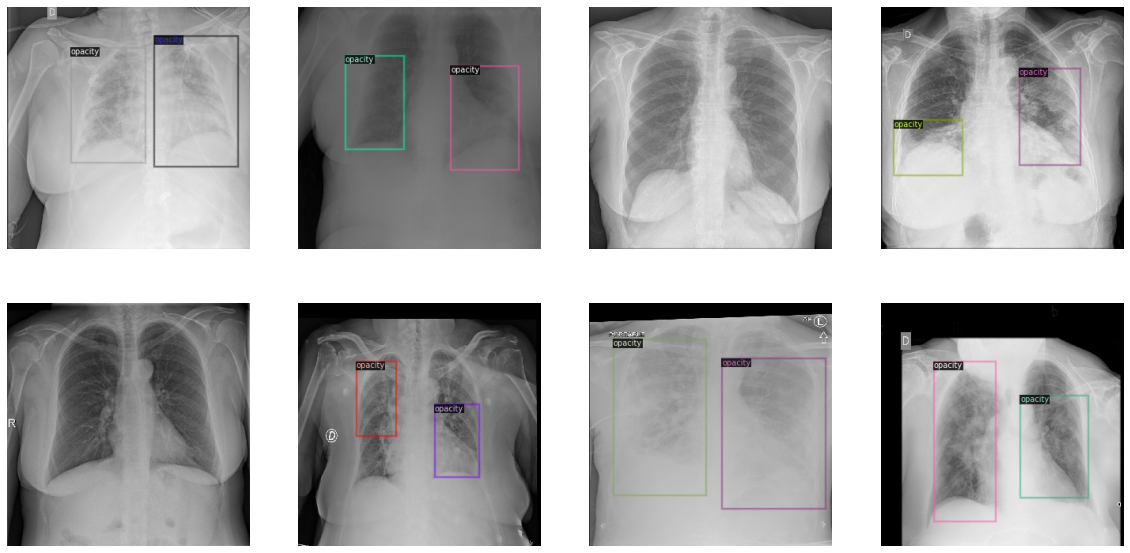

In [6]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = flags.outdir
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)
cfg.DATASETS.TEST = ("COVID19_data_valid",)
cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/


In [8]:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/30 23:45:01 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  2%|▏         | 82/4813 [00:00<00:05, 813.39it/s]

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-10, 10)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
  GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating dat

100%|██████████| 4813/4813 [00:05<00:00, 803.54it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:45:08 d2.data.build]: Removed 1389 images with no usable annotations. 3424 images left.


[07/30 23:45:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 6255         |
|            |              |
[07/30 23:45:08 d2.data.build]: Using training sampler TrainingSampler
[07/30 23:45:08 d2.data.common]: Serializing 3424 elements to byte tensors and concatenating them all ...
[07/30 23:45:08 d2.data.common]: Serialized dataset takes 1.20 MiB


  0%|          | 0/1217 [00:00<?, ?it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 794.95it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:45:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 1597         |
|            |              |
[07/30 23:45:09 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/30 23:45:09 d2.data.common]: Serialized dataset takes 0.37 MiB


[07/30 23:45:09 d2.engine.train_loop]: Starting training from iteration 0
[07/30 23:45:33 d2.utils.events]:  eta: 1:09:34  iter: 19  total_loss: 1.914  loss_cls: 1.121  loss_box_reg: 0.8533  time: 1.1176  data_time: 0.0283  lr: 4.2996e-05  max_mem: 18669M
[07/30 23:45:54 d2.utils.events]:  eta: 1:09:04  iter: 39  total_loss: 1.122  loss_cls: 0.5366  loss_box_reg: 0.5609  time: 1.0806  data_time: 0.0147  lr: 8.5624e-05  max_mem: 18669M
[07/30 23:46:15 d2.utils.events]:  eta: 1:08:43  iter: 59  total_loss: 0.9694  loss_cls: 0.4436  loss_box_reg: 0.5252  time: 1.0694  data_time: 0.0144  lr: 0.00012825  max_mem: 18669M
[07/30 23:46:36 d2.utils.events]:  eta: 1:08:24  iter: 79  total_loss: 0.9207  loss_cls: 0.4188  loss_box_reg: 0.488  time: 1.0710  data_time: 0.0152  lr: 0.00017088  max_mem: 18669M
[07/30 23:47:02 d2.utils.events]:  eta: 1:08:12  iter: 99  total_loss: 0.9934  loss_cls: 0.4312  loss_box_reg: 0.5371  time: 1.1189  data_time: 0.0170  lr: 0.00021351  max_mem: 18669M
[07/30 23:

[07/31 00:03:03 d2.utils.events]:  eta: 1:08:00  iter: 879  total_loss: 0.7675  loss_cls: 0.3428  loss_box_reg: 0.4304  time: 1.2184  data_time: 0.0179  lr: 0.001876  max_mem: 18669M
[07/31 00:03:29 d2.utils.events]:  eta: 1:07:39  iter: 899  total_loss: 0.7638  loss_cls: 0.3296  loss_box_reg: 0.4399  time: 1.2212  data_time: 0.0188  lr: 0.0019186  max_mem: 18669M
[07/31 00:03:56 d2.utils.events]:  eta: 1:07:16  iter: 919  total_loss: 0.7225  loss_cls: 0.2998  loss_box_reg: 0.4189  time: 1.2240  data_time: 0.0186  lr: 0.0019612  max_mem: 18669M
[07/31 00:04:23 d2.utils.events]:  eta: 1:06:54  iter: 939  total_loss: 0.8  loss_cls: 0.362  loss_box_reg: 0.4593  time: 1.2267  data_time: 0.0182  lr: 0.0020039  max_mem: 18669M
[07/31 00:04:50 d2.utils.events]:  eta: 1:06:30  iter: 959  total_loss: 0.8007  loss_cls: 0.3542  loss_box_reg: 0.4474  time: 1.2293  data_time: 0.0195  lr: 0.0020465  max_mem: 18669M
[07/31 00:05:15 d2.utils.events]:  eta: 1:06:04  iter: 979  total_loss: 0.8036  loss_

  7%|▋         | 80/1217 [00:00<00:01, 796.98it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 815.79it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 00:05:38 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/31 00:05:38 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/31 00:05:38 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/31 00:05:38 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)


  7%|▋         | 81/1217 [00:00<00:01, 805.29it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 820.86it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 00:05:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[07/31 00:05:39 d2.data.datasets.coco]: Conversion finished, #images: 1217, #annotations: 1597
[07/31 00:05:39 d2.data.datasets.coco]: Caching COCO format annotations at 'results/inference/COVID19_data_valid_coco_format.json' ...
[07/31 00:05:39 d2.evaluation.evaluator]: Start inference on 1217 images
[07/31 00:05:40 d2.evaluation.evaluator]: Inference done 11/1217. 0.0529 s / img. ETA=0:01:05
[07/31 00:05:45 d2.evaluation.evaluator]: Inference done 102/1217. 0.0533 s / img. ETA=0:01:01
[07/31 00:05:50 d2.evaluation.evaluator]: Inference done 193/1217. 0.0533 s / img. ETA=0:00:56
[07/31 00:05:55 d2.evaluation.evaluator]: Inference done 284/1217. 0.0533 s / img. ETA=0:00:51
[07/31 00:06:00 d2.evaluation.evaluator]: Inference done 374/1217. 0.0535 s / img. ETA=0:00:46
[07/31 00:06:05 d2.evaluation.evaluator]: Inference done 465/1217. 0.0535 s / img. ETA=0:00:41
[07/31 00:06:10 d2.evaluation.evaluator]: Inference done 555/1217. 0.0535 s / img. ETA=0:00:36
[07/31 00:06:15 d2.evaluation.eva

[07/31 00:14:04 d2.utils.events]:  eta: 0:57:40  iter: 1339  total_loss: 0.7458  loss_cls: 0.3116  loss_box_reg: 0.4126  validation_loss: 0.7736  time: 1.1826  data_time: 0.0176  lr: 0.0018702  max_mem: 18669M
[07/31 00:14:25 d2.utils.events]:  eta: 0:57:14  iter: 1359  total_loss: 0.773  loss_cls: 0.3374  loss_box_reg: 0.4348  validation_loss: 0.7736  time: 1.1807  data_time: 0.0168  lr: 0.0018531  max_mem: 18669M
[07/31 00:14:46 d2.utils.events]:  eta: 0:56:48  iter: 1379  total_loss: 0.7642  loss_cls: 0.3139  loss_box_reg: 0.4429  validation_loss: 0.7736  time: 1.1788  data_time: 0.0169  lr: 0.0018358  max_mem: 18669M
[07/31 00:15:07 d2.utils.events]:  eta: 0:56:22  iter: 1399  total_loss: 0.681  loss_cls: 0.2869  loss_box_reg: 0.3926  validation_loss: 0.7736  time: 1.1769  data_time: 0.0168  lr: 0.0018184  max_mem: 18669M
[07/31 00:15:28 d2.utils.events]:  eta: 0:55:56  iter: 1419  total_loss: 0.7216  loss_cls: 0.2999  loss_box_reg: 0.4205  validation_loss: 0.7736  time: 1.1752  da

  7%|▋         | 83/1217 [00:00<00:01, 824.89it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 817.02it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 00:26:17 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/31 00:26:17 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/31 00:26:17 d2.evaluation.evaluator]: Start inference on 1217 images
[07/31 00:26:18 d2.evaluation.evaluator]: Inference done 11/1217. 0.0667 s / img. ETA=0:01:22
[07/31 00:26:23 d2.evaluation.evaluator]: Inference done 84/1217. 0.0669 s / img. ETA=0:01:17
[07/31 00:26:28 d2.evaluation.evaluator]: Inference done 158/1217. 0.0665 s / img. ETA=0:01:12
[07/31 00:26:33 d2.evaluation.evaluator]: Inference done 249/1217. 0.0617 s / img. ETA=0:01:01
[07/31 00:26:38 d2.evaluation.evaluator]: Inference done 340/1217. 0.0594 s / img. ETA=0:00:53
[07/31 00:26:43 d2.evaluation.evaluator]: Inference done 430/1217. 0.0583 s / img. ETA=0:00:47
[07/31 00:26:48 d2.evaluation.evaluator]: Inference done 521/1217.

[07/31 00:35:03 d2.utils.events]:  eta: 0:29:11  iter: 2339  total_loss: 0.6426  loss_cls: 0.2554  loss_box_reg: 0.3923  validation_loss: 0.76  time: 1.1514  data_time: 0.0170  lr: 0.00092111  max_mem: 18669M
[07/31 00:35:24 d2.utils.events]:  eta: 0:28:51  iter: 2359  total_loss: 0.7189  loss_cls: 0.2909  loss_box_reg: 0.4128  validation_loss: 0.76  time: 1.1508  data_time: 0.0173  lr: 0.0009022  max_mem: 18669M
[07/31 00:35:46 d2.utils.events]:  eta: 0:28:30  iter: 2379  total_loss: 0.7649  loss_cls: 0.3202  loss_box_reg: 0.4565  validation_loss: 0.76  time: 1.1500  data_time: 0.0168  lr: 0.00088339  max_mem: 18669M
[07/31 00:36:07 d2.utils.events]:  eta: 0:28:10  iter: 2399  total_loss: 0.6532  loss_cls: 0.2536  loss_box_reg: 0.3955  validation_loss: 0.76  time: 1.1492  data_time: 0.0171  lr: 0.00086466  max_mem: 18669M
[07/31 00:36:28 d2.utils.events]:  eta: 0:27:50  iter: 2419  total_loss: 0.6854  loss_cls: 0.2803  loss_box_reg: 0.406  validation_loss: 0.76  time: 1.1485  data_tim

  6%|▋         | 79/1217 [00:00<00:01, 788.98it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 783.91it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 00:47:09 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/31 00:47:09 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/31 00:47:09 d2.evaluation.evaluator]: Start inference on 1217 images


[07/31 00:47:10 d2.evaluation.evaluator]: Inference done 11/1217. 0.0532 s / img. ETA=0:01:05
[07/31 00:47:15 d2.evaluation.evaluator]: Inference done 102/1217. 0.0536 s / img. ETA=0:01:01
[07/31 00:47:20 d2.evaluation.evaluator]: Inference done 193/1217. 0.0536 s / img. ETA=0:00:56
[07/31 00:47:25 d2.evaluation.evaluator]: Inference done 284/1217. 0.0536 s / img. ETA=0:00:51
[07/31 00:47:30 d2.evaluation.evaluator]: Inference done 375/1217. 0.0535 s / img. ETA=0:00:46
[07/31 00:47:35 d2.evaluation.evaluator]: Inference done 464/1217. 0.0537 s / img. ETA=0:00:41
[07/31 00:47:40 d2.evaluation.evaluator]: Inference done 555/1217. 0.0537 s / img. ETA=0:00:36
[07/31 00:47:45 d2.evaluation.evaluator]: Inference done 646/1217. 0.0537 s / img. ETA=0:00:31
[07/31 00:47:50 d2.evaluation.evaluator]: Inference done 737/1217. 0.0537 s / img. ETA=0:00:26
[07/31 00:47:55 d2.evaluation.evaluator]: Inference done 827/1217. 0.0537 s / img. ETA=0:00:21
[07/31 00:48:00 d2.evaluation.evaluator]: Inference

[07/31 00:56:25 d2.utils.events]:  eta: 0:11:19  iter: 3359  total_loss: 0.6911  loss_cls: 0.2858  loss_box_reg: 0.4019  validation_loss: 0.7464  time: 1.1396  data_time: 0.0171  lr: 0.00015509  max_mem: 18669M
[07/31 00:56:48 d2.utils.events]:  eta: 0:10:58  iter: 3379  total_loss: 0.6673  loss_cls: 0.2683  loss_box_reg: 0.3901  validation_loss: 0.7464  time: 1.1396  data_time: 0.0172  lr: 0.00014575  max_mem: 18669M
[07/31 00:57:10 d2.utils.events]:  eta: 0:10:37  iter: 3399  total_loss: 0.7261  loss_cls: 0.2935  loss_box_reg: 0.4293  validation_loss: 0.7464  time: 1.1395  data_time: 0.0171  lr: 0.00013669  max_mem: 18669M
[07/31 00:57:33 d2.utils.events]:  eta: 0:10:17  iter: 3419  total_loss: 0.706  loss_cls: 0.2903  loss_box_reg: 0.3996  validation_loss: 0.7464  time: 1.1395  data_time: 0.0169  lr: 0.0001279  max_mem: 18669M
[07/31 00:57:56 d2.utils.events]:  eta: 0:10:00  iter: 3439  total_loss: 0.6754  loss_cls: 0.2687  loss_box_reg: 0.4067  validation_loss: 0.7464  time: 1.1394

  7%|▋         | 81/1217 [00:00<00:01, 803.00it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 811.13it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 01:08:04 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/31 01:08:04 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/31 01:08:04 d2.evaluation.evaluator]: Start inference on 1217 images
[07/31 01:08:05 d2.evaluation.evaluator]: Inference done 11/1217. 0.0574 s / img. ETA=0:01:10
[07/31 01:08:10 d2.evaluation.evaluator]: Inference done 91/1217. 0.0604 s / img. ETA=0:01:10
[07/31 01:08:15 d2.evaluation.evaluator]: Inference done 175/1217. 0.0591 s / img. ETA=0:01:03
[07/31 01:08:20 d2.evaluation.evaluator]: Inference done 257/1217. 0.0592 s / img. ETA=0:00:58
[07/31 01:08:25 d2.evaluation.evaluator]: Inference done 337/1217. 0.0593 s / img. ETA=0:00:54
[07/31 01:08:30 d2.evaluation.evaluator]: Inference done 422/1217. 0.0588 s / img. ETA=0:00:48
[07/31 01:08:35 d2.evaluation.evaluator]: Inference done 506/1217.

  7%|▋         | 81/1217 [00:00<00:01, 804.41it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/004cbd797cd1.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1217/1217 [00:01<00:00, 802.56it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 01:10:49 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[07/31 01:10:49 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/31 01:10:49 d2.evaluation.evaluator]: Start inference on 1217 images
[07/31 01:10:50 d2.evaluation.evaluator]: Inference done 11/1217. 0.0655 s / img. ETA=0:01:20
[07/31 01:10:55 d2.evaluation.evaluator]: Inference done 85/1217. 0.0658 s / img. ETA=0:01:16
[07/31 01:11:00 d2.evaluation.evaluator]: Inference done 159/1217. 0.0658 s / img. ETA=0:01:11
[07/31 01:11:05 d2.evaluation.evaluator]: Inference done 233/1217. 0.0659 s / img. ETA=0:01:06
[07/31 01:11:10 d2.evaluation.evaluator]: Inference done 306/1217. 0.0660 s / img. ETA=0:01:02
[07/31 01:11:15 d2.evaluation.evaluator]: Inference done 379/1217. 0.0662 s / img. ETA=0:00:57
[07/31 01:11:20 d2.evaluation.evaluator]: Inference done 451/1217.

In [9]:
evaluator = COCOEvaluator("COVID19_data_train", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/31 01:12:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/31 01:12:14 d2.evaluation.coco_evaluation]: 'COVID19_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/31 01:12:14 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_train' to COCO format ...)


  0%|          | 0/4813 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4813/4813 [00:06<00:00, 786.71it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 01:12:20 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/31 01:12:21 d2.data.datasets.coco]: Conversion finished, #images: 4813, #annotations: 6255
[07/31 01:12:21 d2.data.datasets.coco]: Caching COCO format annotations at './results/COVID19_data_train_coco_format.json' ...


  0%|          | 0/4813 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4813/4813 [00:05<00:00, 816.09it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_4_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/31 01:12:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/31 01:12:27 d2.data.common]: Serializing 4813 elements to byte tensors and concatenating them all ...
[07/31 01:12:27 d2.data.common]: Serialized dataset takes 1.46 MiB
[07/31 01:12:27 d2.evaluation.evaluator]: Start inference on 4813 images
[07/31 01:12:28 d2.evaluation.evaluator]: Inference done 11/4813. 0.0479 s / img. ETA=0:03:54
[07/31 01:12:33 d2.evaluation.evaluator]: Inference done 141/4813. 0.0381 s / img. ETA=0:03:02
[07/31 01:12:38 d2.evaluation.evaluator]: Inference done 273/4813. 0.0377 s / img. ETA=0:02:54
[07/31 01:12:43 d2.evaluation.evaluator]: Inference done 408/4813. 0.0373 s / img. ETA=0:02:47
[07/31 01:12:48 d2.evaluation.evaluator]: Inference done 537/4813. 0.0375 

OrderedDict([('bbox',
              {'AP': 19.109952080929798,
               'AP50': 55.84148274651491,
               'AP75': 7.364639630678162,
               'APs': nan,
               'APm': 5.00915558447769,
               'APl': 19.30230173103608})])

In [10]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.014606,4174.050179,19,0.853284,1.121087,4.299629e-05,54.6250,1.048756,1.914154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.014452,4144.114806,39,0.560851,0.536584,8.562396e-05,49.9375,1.046295,1.121900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014200,4123.243301,59,0.525200,0.443576,1.282516e-04,53.0625,1.046711,0.969352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.014594,4104.706888,79,0.488021,0.418776,1.708793e-04,52.8125,1.049217,0.920690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.016449,4092.866667,99,0.537112,0.431197,2.135070e-04,51.1250,1.317484,0.993441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017103,65.073516,3939,0.381422,0.279505,1.434288e-06,52.9375,1.055331,0.659902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.017175,43.382344,3959,0.359239,0.254374,6.480223e-07,52.1250,1.053421,0.613578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.016720,21.710234,3979,0.379031,0.283044,1.700155e-07,49.1250,1.053957,0.661870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.017037,0.000000,3999,0.391110,0.258975,3.855314e-10,33.0000,1.155932,0.645436,17.227039,52.044638,6.421908,17.529527,0.396138,NaN,0.742285


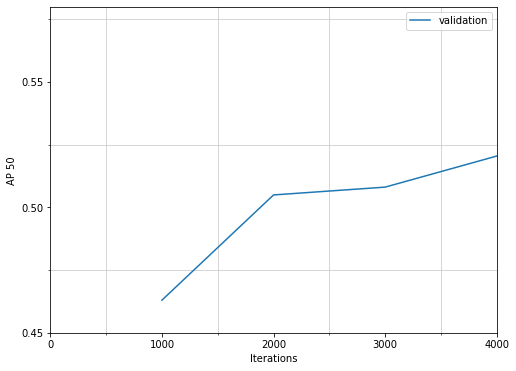

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.45, 0.58)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50.png")

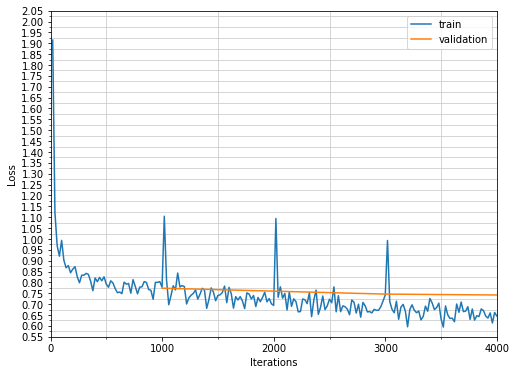

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.55, 2.05)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss.png")